# Entrega ML 1
David Prokes

### Introducción
El objetivo de la prática consiste en clasificar y evaluar diferentes algoritmos de clasificación de Machine Learning.

Los datos son imágenes de escasa resolución (32 x 32 píxeles) de objetos reales (por ejemplo: un oso, un avión, un tren, etc.). Los datos están separados en varios ficheros:

```bash
├── batches.meta dispone de información descriptiva de las etiquetas usadas
├── data_batch_1  datos_lote_1
├── data_batch_2  datos_lote_2
├── data_batch_3  datos_lote_3
├── data_batch_4  datos_lote_4
├── data_batch_5  datos_lote_5
└── test_batch    muestras que podrían utilizarse como test
```

Estos ficheros se proporcionan en formato binario por su elevado tamaño. En concreto, cada lote contiene una parte del conjunto completo de datos, por lo que se deben unificar todas estas partes en un único conjunto de datos y etiquetas.

Por otra parte, cada imagen se compone de 3072 píxeles correspondientes a la escala RGB: (0-1024), (1024-2048) y (2048-3072).

### Preparación de los datos

In [1]:
# Cargamos todas las librerías necesarias: 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

# Creamos la función para la carga de datos en formato binario propio de pandas (pickle):
def unpickle(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data

# Cargamos todos los lotes de datos:
meta = unpickle('datos_practica_ML1/datos_practica_ML1/batches.meta')
data_batch_1 = unpickle('datos_practica_ML1\datos_practica_ML1\data_batch_1')
data_batch_2 = unpickle('datos_practica_ML1\datos_practica_ML1\data_batch_2')
data_batch_3 = unpickle('datos_practica_ML1\datos_practica_ML1\data_batch_3')
data_batch_4 = unpickle('datos_practica_ML1\datos_practica_ML1\data_batch_4')
data_batch_5 = unpickle('datos_practica_ML1\datos_practica_ML1\data_batch_5')
test_batch = unpickle('datos_practica_ML1/datos_practica_ML1/test_batch')

# Creamos una función para concatenar los datos de los lotes:
def concatenar_datos(data_batches):
    datos = []      # Lista para almacenar los píxeles de las imágenes.
    etiquetas = []  # Lista para almacenar las etiquetas.
    
    for batch in data_batches:
        datos.append(batch[b'data'])       # Añade los datos de imágenes.
        etiquetas.extend(batch[b'labels']) # Añade las etiquetas de cada lote.
    
    # Convertimos las listas en arrays numpy:
    datos_combinados = np.vstack(datos)       # Une las matrices de imágenes.
    etiquetas_combinadas = np.array(etiquetas) # Convierte etiquetas a numpy.
    
    return datos_combinados, etiquetas_combinadas

# Creamos la lista con todos los lotes cargados:
batches = [data_batch_1, data_batch_2, data_batch_3, data_batch_4, data_batch_5]

# Concatenamos los lotes:
x, y = concatenar_datos(batches)

# Aplicamos lo mismo pero para los datos de test:
x_test, y_test = concatenar_datos([test_batch])

# Convertimos los datos a formato adecuado para los modelos:
x = x.astype('float32')
x_test = x_test.astype('float32')

# Convertimos los nombres de las etiquetas a cadenas de texto (str):
labels = [label.decode('utf-8') for label in meta[b'label_names']]


**1. Analiza con mayor detalle la dimensionalidad de los datos. En esta sección se valorará el uso de gráficos.**

In [2]:
# Mostramos las dimensiones de los datos combinados:
print(f"Dimensiones de las imágenes de entrenamiento: {x.shape}")
print(f"Dimensiones de las etiquetas de entrenamiento: {y.shape}")
print(f"Dimensiones de las imágenes de test: {x_test.shape}")
print(f"Dimensiones de las etiquetas de test: {y_test.shape}")

print("_"*50)

# Mostramos la escala de los datos:
print(f"\nRango de valores de cada píxel: {(x.min(), x.max())}")

# Mostramos todas las categorías de las etiquetas:
print(f"Categorías de las etiquetas: {np.unique(y)}")
print("Correspondientes a las siguientes categorías:")
print(labels)

print("_"*50)

# Calculamos la distribución de las etiquetas en el conjunto de entrenamiento:
etiquetas_df = pd.DataFrame({'Etiqueta': list(y)})
print('\nDistribución de etiquetas:')
print(etiquetas_df['Etiqueta'].value_counts().sort_index())

Dimensiones de las imágenes de entrenamiento: (50000, 3072)
Dimensiones de las etiquetas de entrenamiento: (50000,)
Dimensiones de las imágenes de test: (10000, 3072)
Dimensiones de las etiquetas de test: (10000,)
__________________________________________________

Rango de valores de cada píxel: (0.0, 255.0)
Categorías de las etiquetas: [0 1 2 3 4 5 6 7 8 9]
Correspondientes a las siguientes categorías:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
__________________________________________________

Distribución de etiquetas:
Etiqueta
0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: count, dtype: int64


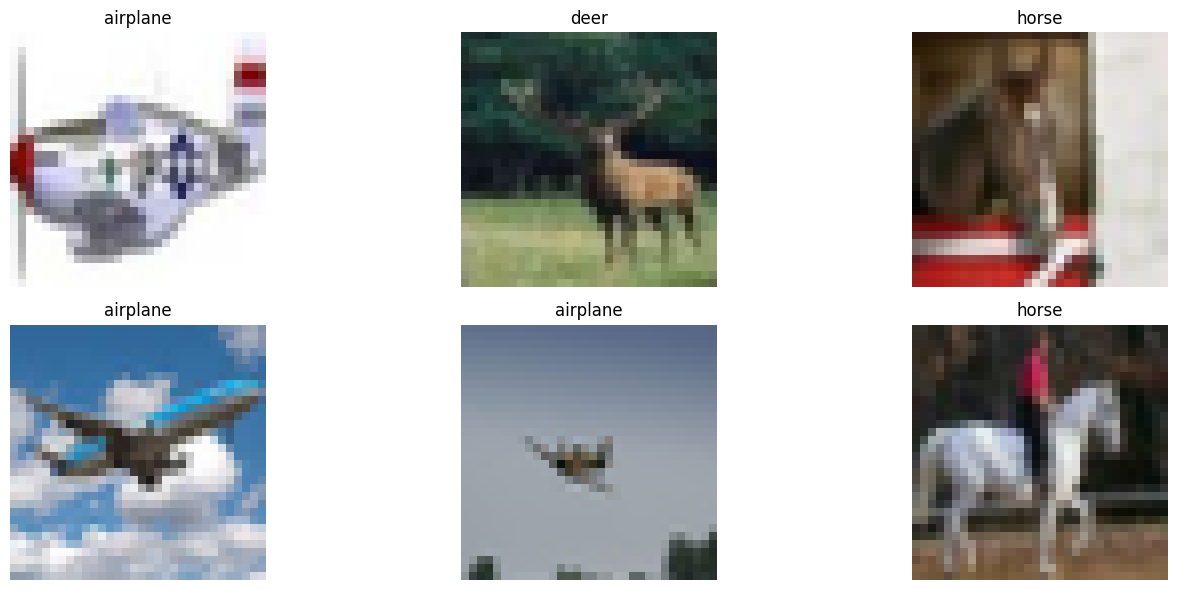

In [3]:
# Creamos una función para visualizar las imágenes de manera aleatoria:
def visualizar_muestras(imagenes, etiquetas, nombres, n=10):
    plt.figure(figsize=(15, 6))
    for i in range(n):
        idx = np.random.randint(len(imagenes))  # Índice aleatorio
        img_red = imagenes[idx][:1024].reshape(32, 32)
        img_green = imagenes[idx][1024:2048].reshape(32, 32)
        img_blue = imagenes[idx][2048:].reshape(32, 32)
        img_rgb = np.dstack((img_red, img_green, img_blue))
        
        plt.subplot(2, (n + 1) // 2, i + 1)
        plt.imshow(img_rgb)
        plt.title(nombres[etiquetas[idx]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Mostramos 6 imágenes aleatorias:
visualizar_muestras(x/255, y, labels, n=6)

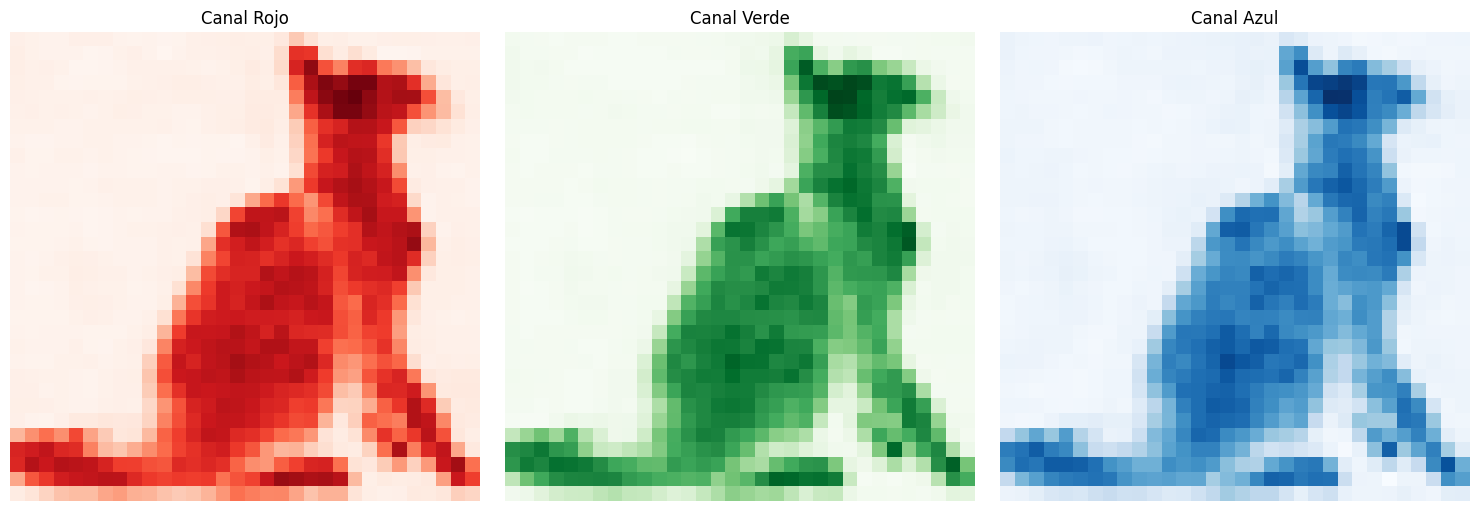

In [4]:
# Creamos una función para visualzar los canales RGB de una imagen:
def visualizar_canales_rgb(imagen):
    # Extraemos cada canal:
    img_red = imagen[:1024].reshape(32, 32)
    img_green = imagen[1024:2048].reshape(32, 32)
    img_blue = imagen[2048:].reshape(32, 32)

    # Creamos imágenes para cada canal:
    plt.figure(figsize=(15, 5))

    # Canal Rojo:
    plt.subplot(1, 3, 1)
    plt.imshow(img_red, cmap='Reds')  # Escala de rojos
    plt.title("Canal Rojo")
    plt.axis('off')

    # Canal Verde:
    plt.subplot(1, 3, 2)
    plt.imshow(img_green, cmap='Greens')  # Escala de verdes
    plt.title("Canal Verde")
    plt.axis('off')

    # Canal Azul:
    plt.subplot(1, 3, 3)
    plt.imshow(img_blue, cmap='Blues')  # Escala de azules
    plt.title("Canal Azul")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Caso de ejemplo:
visualizar_canales_rgb(x[11234])

Con el anterior código podemos visualizar y entender los 3072 píxeles de los que se compone cada imagen, correspondientes a la escala RGB.

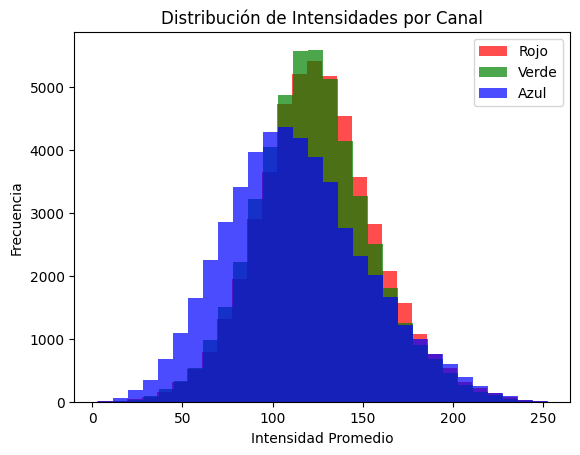

In [5]:
# Calcular intensidades promedio por canal
intensidades_rojo = [img[:1024].mean() for img in x]
intensidades_verde = [img[1024:2048].mean() for img in x]
intensidades_azul = [img[2048:].mean() for img in x]

# Crear histogramas
plt.hist(intensidades_rojo, bins=30, alpha=0.7, label='Rojo', color='red')
plt.hist(intensidades_verde, bins=30, alpha=0.7, label='Verde', color='green')
plt.hist(intensidades_azul, bins=30, alpha=0.7, label='Azul', color='blue')
plt.title("Distribución de Intensidades por Canal")
plt.xlabel("Intensidad Promedio")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

El canal azul está desplazado hacia valores más bajos en comparación con el rojo y el verde. Esto indica que, en promedio, los píxeles de las imágenes tienen una intensidad más baja para el canal azul.

**2. Selecciona datos para entrenar un modelo de clasificación usando la librería scikit-learn con tan solo las entidades de tres categorías elegidas al azar por el sistema. Importante: si así lo considerás no hace falta que selecciones todas las muestras de esos tipos que hay en todos los lotes!**

In [6]:
# Primero de todo importamos las funciones necesarias de sklearn:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Fijamos una semilla aleatoria para garantizar reproducibilidad:
np.random.seed(11631)

# Seleccionamos tres categorías aleatorias:
labels_objetivo = np.random.choice(labels, size=3, replace=False)
print(f"Categorías seleccionadas: {labels_objetivo}")

# Obtenemos los correspondientes índices de las categorías seleccionadas:
y_objetivo = np.array([labels.index(label) for label in labels_objetivo])
print(f"Índices de las categorías seleccionadas: {y_objetivo}")

# Filtramos las imágenes y etiquetas correspondientes a las categorías seleccionadas:
train_mask = np.isin(y, y_objetivo)
test_mask = np.isin(y_test, y_objetivo)

x = x[train_mask]
y = y[train_mask]
x_test = x_test[test_mask]
y_test = y_test[test_mask]

# Creamos un subconjunto de datos de entrenamiento:
x_train, _,  y_train, _ = train_test_split(x, y, test_size=0.4, random_state = 11631)

# Normalizamos los datos:
x_train_1 = x_train / 255.0
x_test_1 = x_test / 255.0

# Mostramos las dimensiones de los datos combinados:
print(f"Dimensiones de las imágenes de entrenamiento: {x_train.shape}")
print(f"Dimensiones de las etiquetas de entrenamiento: {y_train.shape}")
print(f"Dimensiones de las imágenes de test: {x_test.shape}")
print(f"Dimensiones de las etiquetas de test: {y_test.shape}")


Categorías seleccionadas: ['bird' 'frog' 'truck']
Índices de las categorías seleccionadas: [2 6 9]
Dimensiones de las imágenes de entrenamiento: (9000, 3072)
Dimensiones de las etiquetas de entrenamiento: (9000,)
Dimensiones de las imágenes de test: (3000, 3072)
Dimensiones de las etiquetas de test: (3000,)


**3. Aplica, configura y analiza los resultados tras aplicar los siguientes algoritmos de clasificación sobre los datos seleccionados previamente (se valorarán el estudio de diferentes parametrizaciones):**
  - Support Vector Machine
  - Random Forest Classifier
  - K Neighbors Classifier
  - AdaBoots

*Modelo SVM con núcleo lineal y Validación Cruzada 5-veces*

In [28]:
# Definimos el espacio de búsqueda de hiperparámetros:
M1_grid = {'C': [0.001, 0.01, 0.1, 1, 5]}

# Creamos un modelo SVM con kernel lineal y Validación Cruzada 5-veces:
M1_VC = GridSearchCV(SVC(kernel='linear', random_state=11631), 
                         M1_grid,  # Diccionario con los hiperparámetros
                         cv=5,  # Validación cruzada con 5 particiones
                         scoring='accuracy',  # Métrica de evaluación
                         verbose=1)  # Muestra el progreso

# Entrenamos el modelo con los datos de entrenamiento:
M1_VC.fit(x_train_1[:900,], y_train[:900,])

# Buscamos el valor óptimo del coste en función de la precisión:
M1_VC_cost = M1_VC.best_params_['C']

# Creamos un modelo SVM con kernel lineal y el coste óptimo:
M1 = SVC(kernel='linear', 
         C=M1_VC_cost, 
         random_state=11631)

# Entrenamos el modelo con los datos de entrenamiento:
M1.fit(x_train_1[:3000,], y_train[:3000,])

# Generamos predicciones sobre el conjunto de prueba:
M1_pred = M1.predict(x_test_1)

# Calculamos varias métricas de evaluación:
print(classification_report(y_test, M1_pred, target_names=['bird', 'frog', 'truck']))

# Obtenemos la matriz de confusión:
M1_conf = confusion_matrix(y_test, M1_pred)

# Convertimos la matriz en un DataFrame con etiquetas:
M1_conf = pd.DataFrame(M1_conf, 
                       index=['bird', 'frog', 'truck'], 
                       columns=['bird', 'frog', 'truck'])

print("\nMatriz de Confusión:")
print(M1_conf)

print("\nCoste óptimo:", M1_VC_cost)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
              precision    recall  f1-score   support

        bird       0.65      0.64      0.65      1000
        frog       0.65      0.72      0.68      1000
       truck       0.85      0.76      0.81      1000

    accuracy                           0.71      3000
   macro avg       0.72      0.71      0.71      3000
weighted avg       0.72      0.71      0.71      3000


Matriz de Confusión:
       bird  frog  truck
bird    643   285     72
frog    215   723     62
truck   129   107    764

Coste óptimo: 0.01


El SVM con núcleo lineal y un coste óptimo de 0.01 ha obtenido una capacidad predictiva del 71%. Con especial dificultad en clasificar la categoría *bird*.

*Modelo SVM con núcleo radial y Validación Cruzada 5-veces*

In [29]:
# Definimos el espacio de búsqueda de hiperparámetros:
M2_grid = {'C': [0.01, 0.1, 1, 5, 10],
        'gamma': [0.001, 0.01, 0.1, 1, 5]}

# Creamos un modelo SVM con kernel rbf y Validación Cruzada 5-veces:
M2_VC = GridSearchCV(SVC(kernel='rbf', random_state=11631), 
                         M2_grid,  # Diccionario con los hiperparámetros
                         cv=5,  # Validación cruzada con 5 particiones
                         scoring='accuracy',  # Métrica de evaluación
                         verbose=1)  # Muestra el progreso

# Entrenamos el modelo con los datos de entrenamiento:
M2_VC.fit(x_train_1[:600], y_train[:600,])

# Buscamos el valor óptimo del coste y gamma en función de la precisión:
M2_VC_cost = M2_VC.best_params_['C']
M2_VC_gamma = M2_VC.best_params_['gamma']

# Creamos un modelo SVM con kernel rbf y los parámetros óptimos:
M2 = SVC(kernel='rbf', 
         C=M2_VC_cost, 
         gamma=M2_VC_gamma,
         random_state=11631)

# Entrenamos el modelo con los datos de entrenamiento:
M2.fit(x_train_1[:2500,], y_train[:2500,])

# Generamos predicciones sobre el conjunto de prueba:
M2_pred = M2.predict(x_test_1)

# Calculamos varias métricas de evaluación:
print(classification_report(y_test, M2_pred, target_names=['bird', 'frog', 'truck']))

# Obtenemos la matriz de confusión:
M2_conf = confusion_matrix(y_test, M2_pred)

# Convertimos la matriz en un DataFrame con etiquetas:
M2_conf = pd.DataFrame(M2_conf, 
                       index=['bird', 'frog', 'truck'], 
                       columns=['bird', 'frog', 'truck'])

print("\nMatriz de Confusión:")
print(M2_conf)

print("\nCoste óptimo:", M2_VC_cost)
print("Gamma óptimo:", M2_VC_gamma)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
              precision    recall  f1-score   support

        bird       0.68      0.68      0.68      1000
        frog       0.69      0.74      0.72      1000
       truck       0.88      0.82      0.85      1000

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000


Matriz de Confusión:
       bird  frog  truck
bird    676   250     74
frog    215   743     42
truck   101    78    821

Coste óptimo: 10
Gamma óptimo: 0.001


El SVM con núcleo radial y un coste y gamma óptimos de 10 y 0.001 respectivamente, ha obtenido una capacidad predictiva del 75%, superior al SVM lineal. Viéndose una ligera mejora en la predicción de la categoría *bird* y una mejora significativa en la categoría *truck*.

*K-Neighbors Classifier y Validación Cruzada 5-veces*

In [30]:
# Definimos el espacio de búsqueda de hiperparámetros:
M3_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Número de vecinos
    'weights': ['uniform', 'distance']  # Tipo de ponderación
}

# Creamos un modelo KNN con Validación Cruzada 5-veces:
M3_VC = GridSearchCV(KNeighborsClassifier(),  # Modelo base
                     M3_grid,                # Diccionario con los hiperparámetros
                     cv=5,                   # Validación cruzada con 5 particiones
                     scoring='accuracy',     # Métrica de evaluación
                     verbose=1)              # Muestra el progreso

# Entrenamos el modelo con los datos de entrenamiento:
M3_VC.fit(x_train_1, y_train)

# Buscamos el valor óptimo de los hiperparámetros:
M3_VC_neighbors = M3_VC.best_params_['n_neighbors']
M3_VC_weights = M3_VC.best_params_['weights']

# Creamos un modelo KNN con los hiperparámetros óptimos:
M3 = KNeighborsClassifier(
    n_neighbors=M3_VC_neighbors,
    weights=M3_VC_weights
)

# Entrenamos el modelo con los datos de entrenamiento:
M3.fit(x_train_1, y_train)

# Generamos predicciones sobre el conjunto de prueba:
M3_pred = M3.predict(x_test_1)

# Calculamos varias métricas de evaluación:
print(classification_report(y_test, M3_pred, target_names=['bird', 'frog', 'truck']))

# Obtenemos la matriz de confusión:
M3_conf = confusion_matrix(y_test, M3_pred)

# Convertimos la matriz en un DataFrame con etiquetas:
M3_conf = pd.DataFrame(M3_conf, 
                       index=['bird', 'frog', 'truck'], 
                       columns=['bird', 'frog', 'truck'])

print("\nMatriz de Confusión:")
print(M3_conf)

print("\nNúmero óptimo de vecinos:", M3_VC_neighbors)
print("Ponderación óptima:", M3_VC_weights)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

        bird       0.48      0.85      0.61      1000
        frog       0.60      0.47      0.53      1000
       truck       0.95      0.42      0.58      1000

    accuracy                           0.58      3000
   macro avg       0.68      0.58      0.57      3000
weighted avg       0.68      0.58      0.57      3000


Matriz de Confusión:
       bird  frog  truck
bird    851   132     17
frog    524   470      6
truck   397   183    420

Número óptimo de vecinos: 9
Ponderación óptima: distance


El modelo de KNN con un número óptimo de 9 vecinos, aplicando la ponderación en base a la distancia, extrae una capacidad predictiva del 58%, muy inferior al resto de modelos. No obstante, destaca por ser el mejor modelo en predecir la categoría de *bird*.

*Random Forest Classification y Validación Cruzada 5-veces*

In [31]:
# Definimos el espacio de búsqueda de hiperparámetros
M4_grid = {
    'n_estimators': [50, 100, 200],       # Número de árboles
    'max_depth': [None, 10, 20],         # Profundidad máxima
    'min_samples_split': [2, 5, 10],     # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]        # Mínimo número de muestras en una hoja
}

# Creamos un modelo Random Forest y GrsidSearch con Validación Cruzada:
M4_VC = GridSearchCV(
    RandomForestClassifier(random_state=11631),
    M4_grid,       # Diccionario con los hiperparámetros
    cv=5,          # Validación cruzada con 5 particiones
    scoring='accuracy',  # Métrica de evaluación
    verbose=1,      # Muestra el progreso
    n_jobs=-1       # Usa todos los núcleos disponibles para entrenar
)

# Entrenamos el modelo con los datos de entrenamiento:
M4_VC.fit(x_train[:600], y_train[:600])

# Buscamos los mejores hiperparámetros
M4_VC_parametros = M4_VC.best_params_

# Creamos el modelo con los hiperparámetros óptimos:
M4 = RandomForestClassifier(
    n_estimators=M4_VC_parametros['n_estimators'],
    max_depth=M4_VC_parametros['max_depth'],
    min_samples_split=M4_VC_parametros['min_samples_split'],
    min_samples_leaf=M4_VC_parametros['min_samples_leaf'],
    random_state=11631
)

# Entrenamos el modelo con los datos de entrenamiento
M4.fit(x_train[:2500,], y_train[:2500,])

# Generamos predicciones sobre el conjunto de prueba
M4_pred = M4.predict(x_test)

# Calculamos varias métricas de evaluación
print(classification_report(y_test, M4_pred, target_names=['bird', 'frog', 'truck']))

# Obtenemos la matriz de confusión
M4_conf = confusion_matrix(y_test, M4_pred)

# Convertimos la matriz en un DataFrame con etiquetas
M4_conf = pd.DataFrame(M4_conf, 
                       index=['bird', 'frog', 'truck'], 
                       columns=['bird', 'frog', 'truck'])

# Mostramos la matriz de confusión
print("\nMatriz de Confusión:")
print(M4_conf)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
              precision    recall  f1-score   support

        bird       0.71      0.66      0.69      1000
        frog       0.69      0.76      0.72      1000
       truck       0.82      0.80      0.81      1000

    accuracy                           0.74      3000
   macro avg       0.74      0.74      0.74      3000
weighted avg       0.74      0.74      0.74      3000


Matriz de Confusión:
       bird  frog  truck
bird    660   235    105
frog    173   755     72
truck    94   105    801


El modelo de Random Forest ha obtenido una capacidad predictiva del 74%, ligeramente inferior al modelo de SVM con núcleo radial. De nuevo, se obtiene una especial dificultad en clasificar la categoría *bird*.

*AdaBoost Classifier*

In [37]:
import warnings

# Suprimimos el warning relacionado con SAMME.R:
warnings.filterwarnings('ignore', category=FutureWarning)

# Definimos el espacio de búsqueda de hiperparámetros:
M5_grid = {
    'n_estimators': [50, 100],  # Número de estimadores (árboles débiles)
    'learning_rate': [0.1, 1]  # Tasa de aprendizaje
}

# Creamos un modelo base (árbol de decisión poco profundo)
modelo_base = DecisionTreeClassifier(max_depth=2, random_state=11631)

# Creamos un modelo AdaBoost con Validación Cruzada 5-veces:
M5_VC = GridSearchCV(AdaBoostClassifier(estimator=modelo_base, algorithm='SAMME.R', random_state=11631),
                     M5_grid,                # Diccionario con los hiperparámetros
                     cv=5,                   # Validación cruzada con 5 particiones
                     scoring='accuracy',     # Métrica de evaluación
                     verbose=1)              # Muestra el progreso

# Entrenamos el modelo con los datos de entrenamiento:
M5_VC.fit(x_train_1[:1000], y_train[:1000,])

# Buscamos el valor óptimo de los hiperparámetros:
M5_VC_estimators = M5_VC.best_params_['n_estimators']
M5_VC_learning_rate = M5_VC.best_params_['learning_rate']

# Creamos un modelo AdaBoost con los hiperparámetros óptimos:
M5 = AdaBoostClassifier(
    estimator=modelo_base,
    n_estimators=M5_VC_estimators,
    learning_rate=M5_VC_learning_rate,
    algorithm='SAMME.R',
    random_state=11631
)

# Entrenamos el modelo con los datos de entrenamiento:
M5.fit(x_train_1[:2500,], y_train[:2500,])

# Generamos predicciones sobre el conjunto de prueba:
M5_pred = M5.predict(x_test_1)

# Calculamos varias métricas de evaluación:
print(classification_report(y_test, M5_pred, target_names=['bird', 'frog', 'truck']))

# Obtenemos la matriz de confusión:
M5_conf = confusion_matrix(y_test, M5_pred)

# Convertimos la matriz en un DataFrame con etiquetas:
M5_conf = pd.DataFrame(M5_conf, 
                       index=['bird', 'frog', 'truck'], 
                       columns=['bird', 'frog', 'truck'])

print("\nMatriz de Confusión:")
print(M5_conf)

print("\nNúmero óptimo de estimadores:", M5_VC_estimators)
print("Tasa de aprendizaje óptima:", M5_VC_learning_rate)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
              precision    recall  f1-score   support

        bird       0.61      0.57      0.59      1000
        frog       0.61      0.74      0.67      1000
       truck       0.86      0.72      0.79      1000

    accuracy                           0.68      3000
   macro avg       0.69      0.68      0.68      3000
weighted avg       0.69      0.68      0.68      3000


Matriz de Confusión:
       bird  frog  truck
bird    569   363     68
frog    206   742     52
truck   162   113    725

Número óptimo de estimadores: 50
Tasa de aprendizaje óptima: 0.1


El modelo AdaBoost obtiene una capacidad predictiva del 68%, significativamente inferior a los modelos SVM y RandomForest.

*Modelo SVM con núcleo polinomial y Validación Cruzada 5-veces*

In [36]:
# Definimos el espacio de búsqueda de hiperparámetros:
M6_grid = {
    'C': [0.01, 0.1, 1, 5, 10],          # Regularización
    'gamma': [0.001, 0.01, 0.1, 1, 5],   # Coeficiente del kernel
    'degree': [2, 3, 4]                  # Grado del polinomio
}

# Creamos un modelo SVM con kernel polinomial y Validación Cruzada 5-veces:
M6_VC = GridSearchCV(SVC(kernel='poly', random_state=11631), 
                     M6_grid,     # Diccionario con los hiperparámetros
                     cv=5,             # Validación cruzada con 5 particiones
                     scoring='accuracy',  # Métrica de evaluación
                     verbose=1)        # Muestra el progreso

# Entrenamos el modelo con un subconjunto de los datos de entrenamiento:
M6_VC.fit(x_train_1[:600], y_train[:600,])

# Buscamos los valores óptimos de los hiperparámetros:
M6_cost = M6_VC.best_params_['C']
M6_gamma = M6_VC.best_params_['gamma']
M6_degree = M6_VC.best_params_['degree']

# Creamos un modelo SVM con kernel polinomial y los hiperparámetros óptimos:
M6 = SVC(
    kernel='poly', 
    C=M6_cost, 
    gamma=M6_gamma,
    degree=M6_degree,
    random_state=11631
)

# Entrenamos el modelo con un conjunto más grande de datos de entrenamiento:
M6.fit(x_train_1[:2500,], y_train[:2500,])

# Generamos predicciones sobre el conjunto de prueba:
M6_pred = M6.predict(x_test_1)

# Calculamos varias métricas de evaluación:
print(classification_report(y_test, M6_pred, target_names=['bird', 'frog', 'truck']))

# Obtenemos la matriz de confusión:
M6_conf = confusion_matrix(y_test, M6_pred)

# Convertimos la matriz en un DataFrame con etiquetas:
M6_conf = pd.DataFrame(M6_conf, 
                       index=['bird', 'frog', 'truck'], 
                       columns=['bird', 'frog', 'truck'])

print("\nMatriz de Confusión:")
print(M6_conf)

print("\nCoste óptimo:", M6_cost)
print("Gamma óptimo:", M6_gamma)
print("Grado del polinomio óptimo:", M6_degree)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
              precision    recall  f1-score   support

        bird       0.68      0.63      0.65      1000
        frog       0.64      0.78      0.71      1000
       truck       0.88      0.76      0.81      1000

    accuracy                           0.72      3000
   macro avg       0.73      0.72      0.72      3000
weighted avg       0.73      0.72      0.72      3000


Matriz de Confusión:
       bird  frog  truck
bird    629   311     60
frog    173   780     47
truck   121   120    759

Coste óptimo: 5
Gamma óptimo: 0.001
Grado del polinomio óptimo: 2


El modelo SVM con núcleo polinomial con coste, gamma y grado del polinomio óptimos de 5, 0.001 y 2 respectivamente, ha obtenido una capacidad predictiva del 72%. Un rendimiento equilibrado entre el modelo SVM con núcleo lineal y con núcleo radial.

**4. Compara los resultados de los algoritmos. En esta sección se valorarán las visualizaciones.**

In [58]:
print(classification_report(y_test, M1_pred, target_names=['bird', 'frog', 'truck']))

              precision    recall  f1-score   support

        bird       0.65      0.64      0.65      1000
        frog       0.65      0.72      0.68      1000
       truck       0.85      0.76      0.81      1000

    accuracy                           0.71      3000
   macro avg       0.72      0.71      0.71      3000
weighted avg       0.72      0.71      0.71      3000



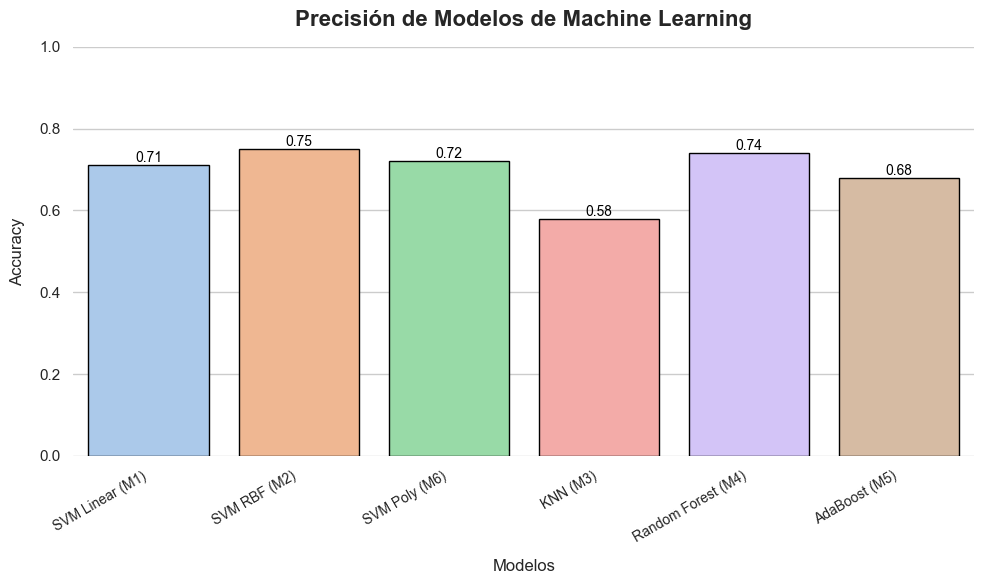

In [66]:
# Recopilamos los resultados de los modelos
resultados = {
    'Modelo': ['SVM Linear (M1)', 'SVM RBF (M2)', 'SVM Poly (M6)', 'KNN (M3)', 'Random Forest (M4)', 'AdaBoost (M5)'],
    'Accuracy': [0.71, 0.75, 0.72, 0.58, 0.74, 0.68]
}

# Crear un DataFrame para comparar los resultados
df_resultados = pd.DataFrame(resultados)

# Estilo de seaborn
sns.set_theme(style="whitegrid")  # Estilo minimalista con cuadrículas suaves

# Crear la gráfica
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
barras = sns.barplot(
    x='Modelo', 
    y='Accuracy', 
    data=df_resultados, 
    palette='pastel',  # Colores pastel automáticos
    edgecolor='black'  # Bordes negros
)

# Añadir etiquetas de valor en cada barra
for barra in barras.patches:
    altura = barra.get_height()
    ax.text(barra.get_x() + barra.get_width() / 2, altura, f'{altura:.2f}', 
            ha='center', va='bottom', fontsize=10, color='black')

# Configuración del gráfico
ax.set_title("Precisión de Modelos de Machine Learning", fontsize=16, fontweight='bold', pad=15)
ax.set_ylabel("Accuracy", fontsize=12, labelpad=10)
ax.set_xlabel("Modelos", fontsize=12, labelpad=10)
ax.set_ylim(0, 1)  # Escala de 0 a 1 para el accuracy

# Limpiar el gráfico eliminando líneas no esenciales
sns.despine(left=True, bottom=True)

plt.xticks(rotation=30, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

El modelo SVM con núcleo radial es el que obtiene una mayor precisión en los datos de prueba, concretamente del 0.75, ligeramente superior al Random Forest con un 0.74. Mientras que, el KNN fue el modelo con peor desempeño, alcanzando solo un 0.58 de capacidad predictiva.

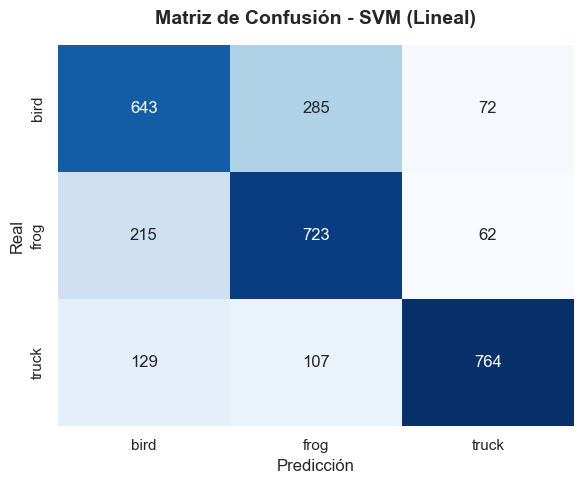

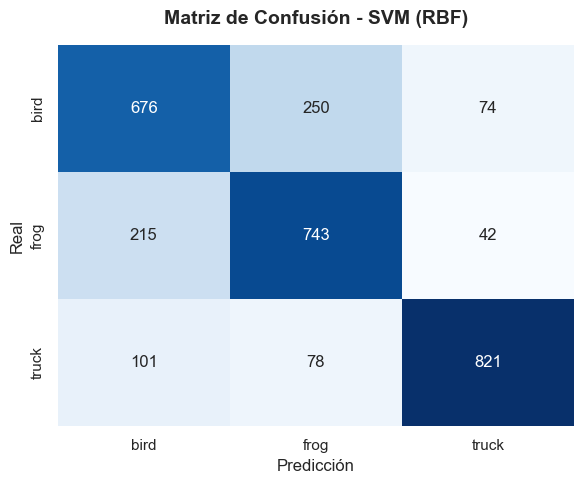

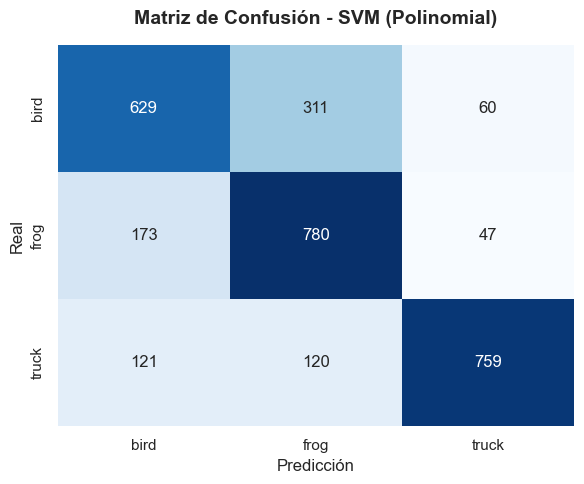

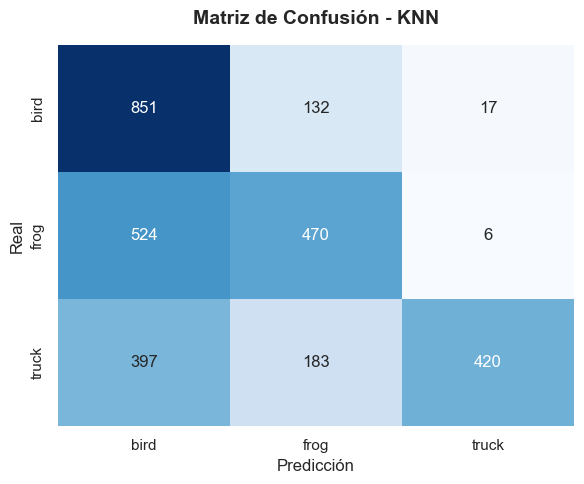

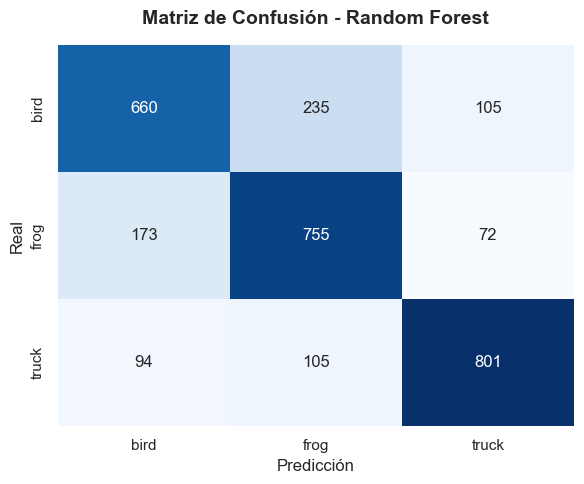

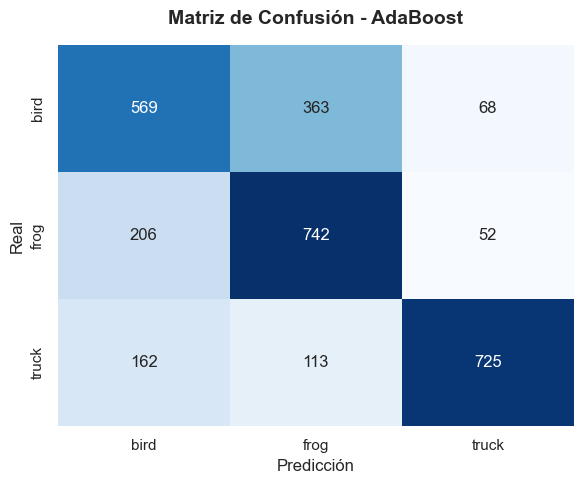

In [69]:
# Función para graficar una matriz de confusión
def plot_confusion_matrix(conf_matrix, title, etiquetas):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=etiquetas, yticklabels=etiquetas)
    plt.title(title, fontsize=14, fontweight='bold', pad=15)
    plt.xlabel("Predicción", fontsize=12)
    plt.ylabel("Real", fontsize=12)
    plt.tight_layout()
    plt.show()

# Etiquetas de las clases
etiquetas = ['bird', 'frog', 'truck']

# Visualizar las matrices de confusión de los modelos
plot_confusion_matrix(M1_conf, "Matriz de Confusión - SVM (Lineal)", etiquetas)
plot_confusion_matrix(M2_conf, "Matriz de Confusión - SVM (RBF)", etiquetas)
plot_confusion_matrix(M6_conf, "Matriz de Confusión - SVM (Polinomial)", etiquetas)
plot_confusion_matrix(M3_conf, "Matriz de Confusión - KNN", etiquetas)
plot_confusion_matrix(M4_conf, "Matriz de Confusión - Random Forest", etiquetas)
plot_confusion_matrix(M5_conf, "Matriz de Confusión - AdaBoost", etiquetas)

En las gráficas anteriores vemos que, el modelo de SVM con núcleo lineal es el que muestra un mejor rendimiento general, logrando elevadas tasas de clasificación correcta y minimizando las confusiones entre clases. No obstante, todos los modelos, a excepción del KNN, han presentado especial dificultad en identificar las imágenes de la categoría *bird*. Todo y que, el modelo de KNN es el que ha experimentado un mayor error en las dos clases restantes. Por otro lado, el Random Forest se posiciona como una alternativa sólida, aunque presenta una ligera dificultad mayor respecto al SVM con núcleo radial, en clasificar la categoría *truck*. Así, en general, SVM RBF es la opción más adecuada para el problema, seguido de cerca por Random Forest.